<a href="https://colab.research.google.com/github/noy2121/Detection-of-the-morties/blob/main/Morties_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
!pip install -U --pre tensorflow=='2.2.0'

In [ ]:
import os
import pathlib

# Clone the tensorflow repo if it doesn't already exits
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

In [ ]:
# Install the object detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [3]:
import matplotlib
import matplotlib.pyplot as plt

import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder 

%matplotlib inline 

## Utilities

In [4]:
def load_image_into_numpy_array(path):
  """Load an image from a file into a numpy array.

  Load image into a numpy array to feed into tensorflow graph.
  By convention (height, width, channels), where channels=3 for RGB

  Args:
    path: file path.
  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (img_width, img_height) = image.size
  return np.array(image.getdata()).reshape(
      (img_height, img_width, 3)).astype(np.uint8)

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12,16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array with shape [N, 4]
    classes: a numpy array of shape [N]. Note the class indices match the
      keys in the label map
    scores: a nump array of shape [N] or None. if None this function assume
      the boxes to be plotted are groundtruth ones and plot all boxes 
      as black with no class or score
    category_index: a dict containing category dictionaries, each holding
      category index `id` and category name `name`, keyd by category indices.
    figsize: figure's size
    image_name: name for the image file
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.8,
      line_thickness=15)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  

## Morties Data

Note that the coco dataset does not contain morties (I think..)

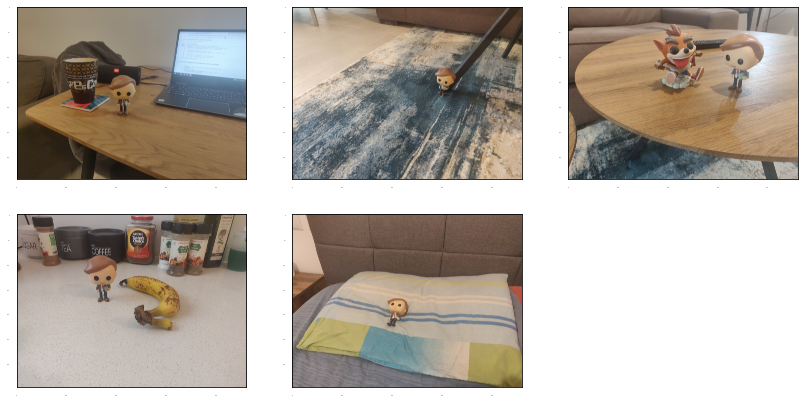

In [5]:
# Load images and visualize
train_image_dir = 'models/research/object_detection/test_images/morties/train'
train_images_np = []
for i in range(1,6):
  image_path = os.path.join(train_image_dir, 'morty' + str(i) + '.jpg')
  train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 3, idx+1)
  plt.imshow(train_image_np)
plt.show()

## Annotate images with bounding boxes

Here we will set up the groundtruth boxes

In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

In [6]:
# If you don't want to annotate yourself, those are the coordinates

gt_boxes = [
            np.array([[0.39444444, 0.39822049, 0.63777778, 0.51909722]], dtype=np.float32),
            np.array([[0.35444444, 0.62051508, 0.52611111, 0.712963  ]], dtype=np.float32),
            np.array([[0.15444444, 0.65653939, 0.50444444, 0.8520689 ]], dtype=np.float32),
            np.array([[0.23944444, 0.28913485, 0.51444444, 0.43583624]], dtype=np.float32),
            np.array([[0.47944444, 0.41348381, 0.65444444, 0.50354457]], dtype=np.float32)
  ]

## Prepare data for training

In [7]:
morty_class_id = 1
num_classes = 1

category_index = {morty_class_id: {'id': morty_class_id, 'name': 'morty_smith'}}

# Convert class lables to one-hot. Convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

Done prepping data.


## Visualize the morties as a sanity check

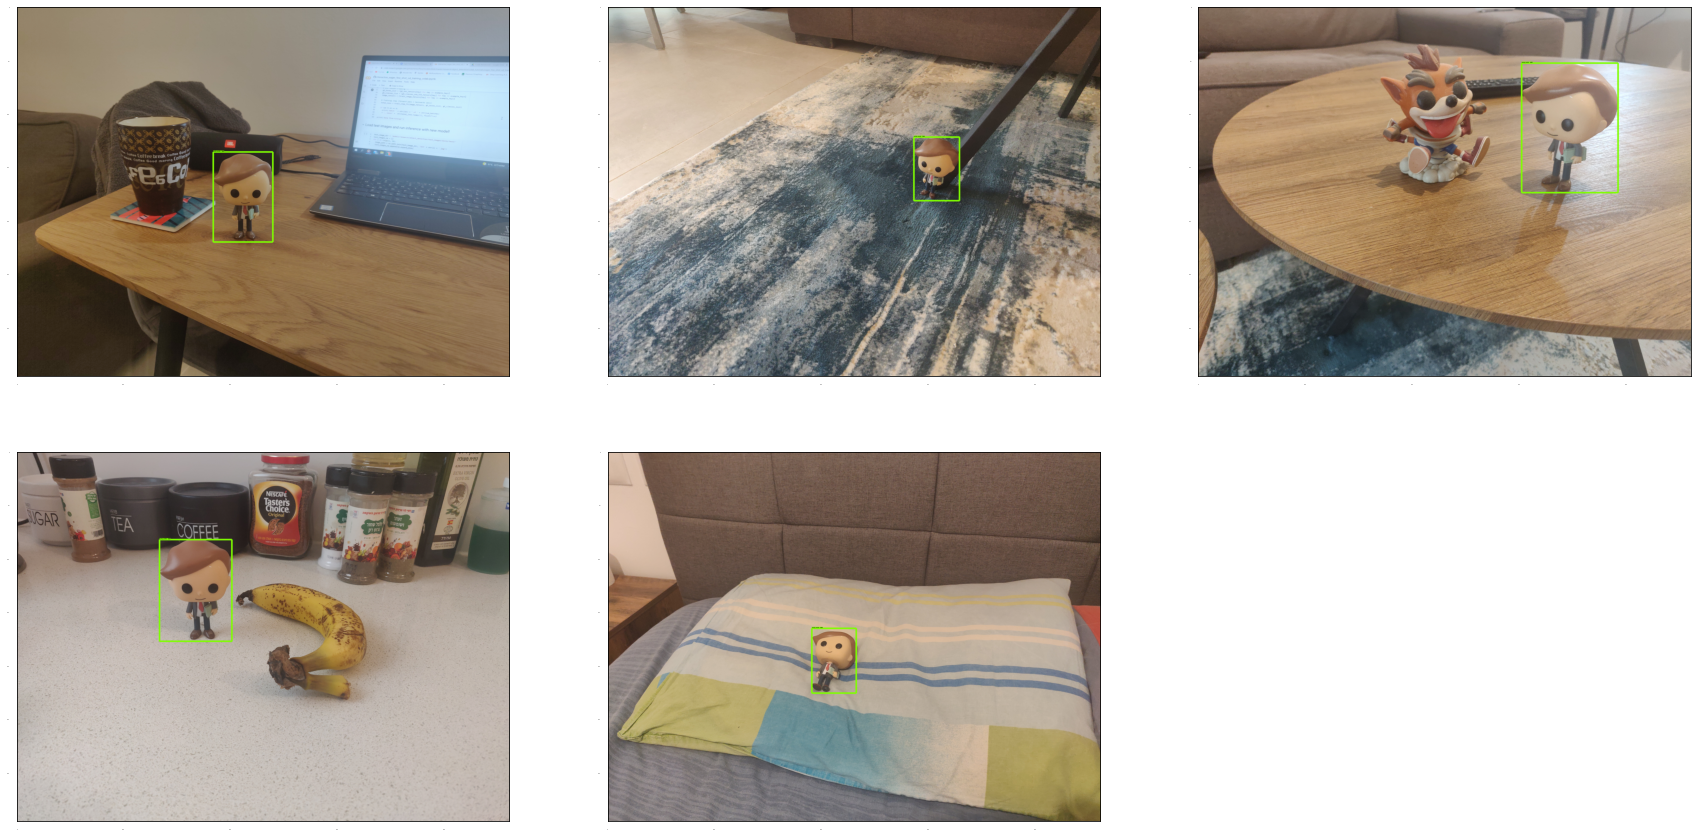

In [8]:
# Give boxes a score of 100% 
dummy_scores = np.array([1.0], dtype=np.float32)

plt.figure(figsize=(30, 15))
for idx in range(5):
  plt.subplot(2, 3, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      dummy_scores, category_index)
plt.show()

## Create Model

Now the fun begins. We will use pre-trained SSD architecture (RetinaNet), and restore all but the classification layer at the top.

In [ ]:
# Download the checkpoint and save it
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

In [10]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build detection model

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    #_prediction_heads=detection_model._box_predictor._prediction_heads,
    #     (i.e. the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that the variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights resotred!')




Building model and restoring weights for fine-tuning...
Weights resotred!


## Training Loop

We will train our network on the 5 morties we saw above. Altough 5 images isn't much, because we're using a pre-trained RetinaNet, by fine-tuning the model we achieve high scores. 

In [12]:
tf.keras.backend.set_learning_phase(True)

# Tuning some of the parameters
batch_size = 4
lr_rate = 0.01
num_batches = 100

# Select variables in top layers to fine-tune
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

# Set up forward + backward pass for a single train step
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for a training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: list of [1, height, width, 3] tensors of type tf.float32.
        The hieght and width can vary across images, as they are reshaped within
        this function to be 640x640
      groundtruth_boxes_list: list of [N_i, 4] tensors of type tf.float32, 
        representing the groundtruth boxes for each image in the batch.
      groundtruth_classes_list: list of [N_i, num_classes] tensors of type 
        tf.float32, representing the groundtruth classes for each image
        in the batch.
    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=lr_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
      detection_model, optimizer, to_fine_tune)
  
print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  # Grab keys for random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward + backward pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches) +
          ', loss=' + str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')  

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:435: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 100, loss=11.346717
batch 10 of 100, loss=3.4105496
batch 20 of 100, loss=1.0280182
batch 30 of 100, loss=0.27701816
batch 40 of 100, loss=0.074752375
batch 50 of 100, loss=0.009311794
batch 60 of 100, loss=0.0041070413
batch 70 of 100, loss=0.00072574546
batch 80 of 100, loss=0.000799192
batch 90 of 100, loss=0.00036635826
Done fine-tuning!


## Load test images and run the new model

In [13]:
test_image_dir = 'models/research/object_detection/test_images/morties/test/'
test_images_np = []
for i in range(6, 23):
  image_path = os.path.join(test_image_dir, 'morty' + str(i) + '.jpg')
  test_images_np.append(np.expand_dims(
      load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="gif_frame_" + ('%02d' % i) + ".jpg")

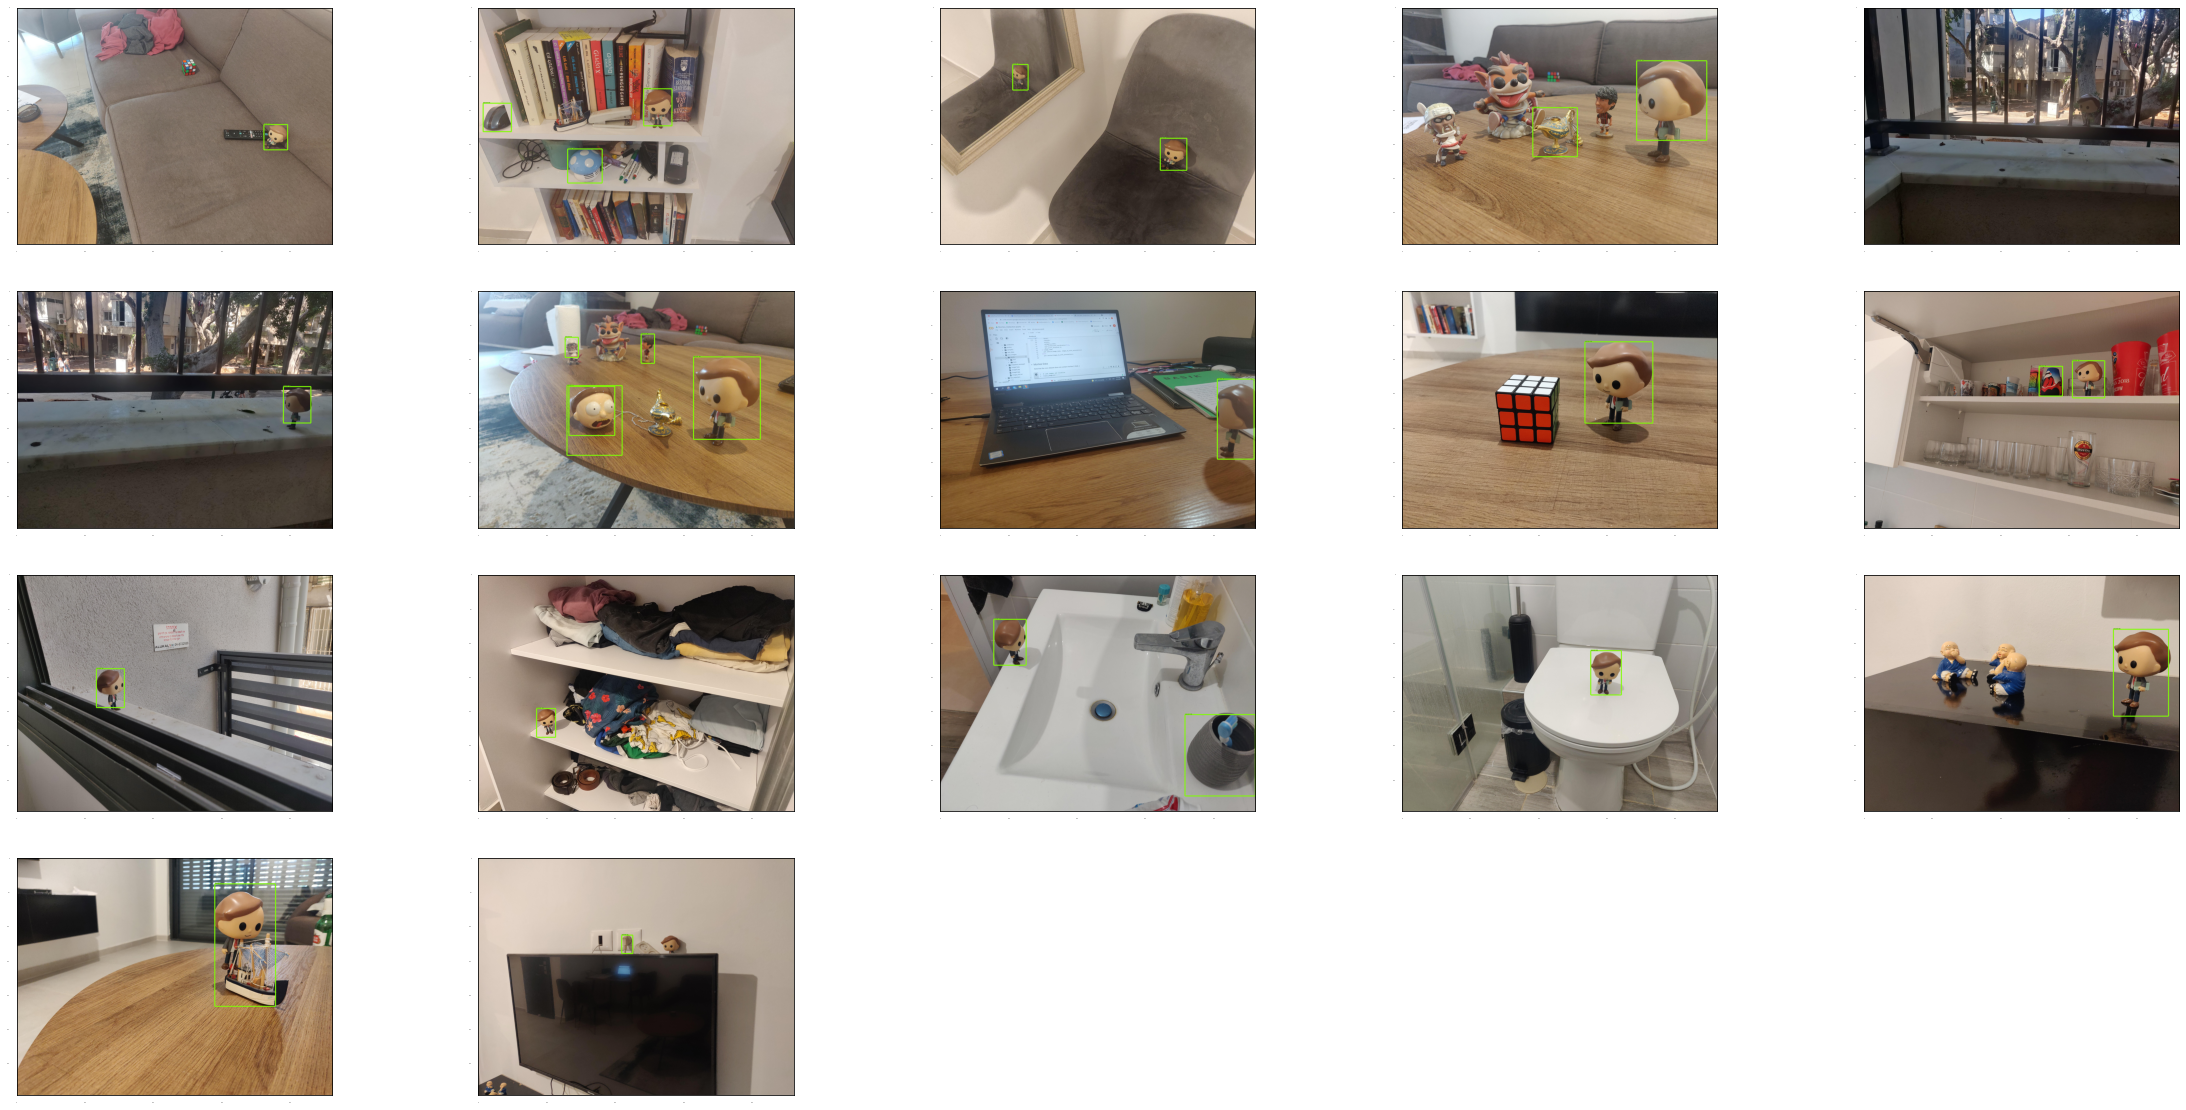

In [25]:
filenames = glob.glob('gif_frame_*.jpg')
filenames = sorted(filenames)
test_images = []

for filename in filenames:
  image = imageio.imread(filename)
  test_images.append(image)

plt.figure(figsize=(40, 20))
for idx, test_image in enumerate(test_images):
  plt.subplot(4, 5, idx+1)
  plt.imshow(test_image)
plt.show()